# Transformer

This notebook gives a demonstration of training a transformer language model on text from project gutenberg. Of course, I am working at a tiny scale compared to the massive resources behind chatgpt etc, but thsi notebook will explain the fundamentals of how those models works.

Under the hood, chatbots like chatgpt are based on generative models with only decoders (not encoders), that predicts what the next token in a sentence will be based on sampling from a the probability distribution. After training the generative model, the chatbots are finetuned to answer questions, but I will only create the generative decoder-model here.

## Installations and Imports

In [ ]:
!pip install keras-nlp

In [ ]:
import os
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import sentencepiece as spm
import requests
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Layer, Input, Embedding, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import keras_nlp
from keras_nlp.layers import TokenAndPositionEmbedding, TransformerDecoder

from sklearn.model_selection import train_test_split

## **Data Collection and Cleaning**


We will use publicly available books from project gutenberg for this transformer. We clean the data to remove some unneccasary data, like headers, footers that are not part of the book, and special characters.

In [ ]:
urls = [
    "https://www.gutenberg.org/cache/epub/1661/pg1661.txt",
    'https://www.gutenberg.org/ebooks/244.txt.utf-8',
    'https://www.gutenberg.org/ebooks/2148.txt.utf-8',
    'https://www.gutenberg.org/ebooks/2852.txt.utf-8',
    'https://www.gutenberg.org/ebooks/2097.txt.utf-8',
    'https://www.gutenberg.org/ebooks/863.txt.utf-8',
    'https://www.gutenberg.org/ebooks/3289.txt.utf-8',
    'https://www.gutenberg.org/ebooks/834.txt.utf-8',
    'https://www.gutenberg.org/ebooks/61262.txt.utf-8',
    'https://www.gutenberg.org/ebooks/108.txt.utf-8',
    'https://www.gutenberg.org/ebooks/155.txt.utf-8',
    'https://www.gutenberg.org/ebooks/58866.txt.utf-8',
    'https://www.gutenberg.org/ebooks/204.txt.utf-8'

]



In [ ]:
def get_books(url):
    return requests.get(url).text


### Cleaning text

I decided to make everything lowercase to keep things simpler. By doing this, I don't have to worry about different spellings of the same word in uppercase and lowercase. It also means the vocabulary is smaller and easier for the model to learn. Although I might lose some information, like which words are proper names, it still helps the model train faster and more easily with the data I have.

In [ ]:
def extract(t):
  cleaned_text = re.sub(
      r'^.*?\*\*\*\s*START OF THE PROJECT GUTENBERG EBOOK.*?\*\*\*',
      '',
      t,
      flags=re.DOTALL | re.IGNORECASE
  )

  cleaned_text = re.sub(
        r'\*\*\*\s*END OF THE PROJECT GUTENBERG EBOOK.*?$',
        '',
        cleaned_text,  # Apply to the already cleaned text
        flags=re.DOTALL | re.IGNORECASE
    )

  # converting text to lowercase and adding start and end token
  cleaned_text = "<START> "+cleaned_text.lower()+" <END>"

  # remove whitespace
  cleaned_text = re.sub(r'[ \t]+', ' ', cleaned_text)

  # remove special characters
  cleaned_text = re.sub(r'[^a-zA-Z0-9 <>*.,;\'?\n]', '', cleaned_text)

  # make multiple newlines to one
  cleaned_text = re.sub(r'\n+', '\n', cleaned_text)

  # remove whitespace/newlines right after start
  cleaned_text = re.sub(r'(<START>)\s+', r'\1', cleaned_text)

  # remove whitespace/newlines right before end
  cleaned_text = re.sub(r'\s+<END>', '<END>', cleaned_text)

  return cleaned_text

Adding all the text into one long string, but with start and end-tokens to know where books are.

In [ ]:
all_text = ""
book_titles = []
book_authors = []

In [ ]:
for u in urls:
  text = get_books(u)
  book_titles.append(text.split('\n')[0][32:].strip())
  all_text += extract(text)

These are the titles we trained on:

In [ ]:

book_titles

['The Adventures of Sherlock Holmes',
 'A Study in Scarlet',
 'The Works of Edgar Allan Poe — Volume 2',
 'The Hound of the Baskervilles',
 'The Sign of the Four',
 'The Mysterious Affair at Styles',
 'The Valley of Fear',
 'The Memoirs of Sherlock Holmes',
 'Poirot Investigates',
 'The Return of Sherlock Holmes',
 'The Moonstone',
 'The Murder on the Links',
 'The innocence of Father Brown']

In [ ]:
#sp_text = "".join(all_text)

In [ ]:
# confirming it is more than 1 mill words
len(all_text.split())

1058158

In [ ]:
# 13 books
len(urls)

13

# Setting parameters

We will now set the important parameters for the model, so we can easily change these and retrain.

- **embed_dim**: Dimensionality of token embeddings.
- **num_heads**: Number of attention heads in the self-attention mechanism.
- **ff_dim**: Hidden dimension of the feed-forward layer inside each transformer block.
- **context**: Number of previous tokens (sequence length) the model sees before predicting the next.
- **n_layer**: Number of stacked transformer blocks.

I selected parametersto get a good balance between complexity and performance. For example, I chose an embedding size of 512 and 8 attention heads. A 512 embedding gives enough details in the language without using too much computing power. 8 attention heads will also train the model to udnerstand different aspects of the sequence in parallel. The heads makes the model better at understanding context.

I also used a feedforward that is four times bigger than embedding. This is a typical practice in transformer models, which was explained in Andrej Karpathys video of transormers. I used a dropout rate of 0.2 to prevent overfitting. I think this level of dropout helped the model perform better on new text.

For the other parameters, I decided to increase the context length to 250 tokens instead of 50 as I intially planned to, as with trial and error, 50 did not work as werll.

 I went with 12 layers to create a reasonable sized transformer model. I chose a batch size of 64 and 50000 samples to make sure it had stable and efficient training.

 I set the epochs to 1000 since I am using early stopping, so the training ends automatically when the model stops improving. This gives the model a lot of time to learn, without me having to guess when to stop training.

In [ ]:
# embed_dim same as from "attention is all you need". In comparison, gpt3 used
# 12 228 dimensions
embed_dim = 512

# in comparison, gpt3 used 96 attention heads
num_heads = 8
ff_dim = 4 * embed_dim
dropout = 0.2
context = 250 # insted of 50 like project proposal

# gpt 3 used 96 layers
n_layer = 12
batch = 64
samples = 50000
epochs = 1000 # I am using earlystop

# using 8000 tokens max in the vocabulary. In comparison, gpt has
# around 50 000
vocab = 8000

# tokenize

When dealing with text, I need to break it down into tokens that a model can understand. I ended up not using the Tokenizer approach from Keras because it mostly works on a word level, which would give me a very large vocabulary and a lot of rare words that don't appear often. That makes training harder.

I am using Googles sentencepiece to tokenize the sentences. THis is a subword tokenizer with byte pair encoding (BPE). It is balancing word and character-level tokenization, using something in between. This keeps the vocabulary at a good and managble size.

Instead, I am stopping sentencepiece at 8000 tokens max, which I think is good for a small model. The gpt models has around 50000 tokens in their vocabulary.



On top of the big vocabulary size, gpt is trained on billions of tokens, from the internet. I just have a small, specific dataset and 50000 tokens to trian the model on.  I do not expect the model to be very good, but this is a good way to learn the architecture.


In [ ]:
# here is an alternative tokenizer
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts([clean_t])
#tokenized_text = tokenizer.texts_to_sequences([clean_t])
#tokenized_text[0][:10]

In [ ]:
# write the text to a file first
with open("sp.txt", "w", encoding="utf-8") as f:
    f.write(all_text)

In [ ]:
# using bpe instead, as tokenizing the words did not give great performance

# training a sentencepiece model
spm.SentencePieceTrainer.train(
    input='/content/sp.txt', model_type = 'bpe', vocab_size=vocab,
    model_prefix='tokenizer',
    user_defined_symbols=['<START>', '<END>']
)

In [ ]:
sp = spm.SentencePieceProcessor()
sp.load('tokenizer.model')


True

In [ ]:
vocab_size = sp.vocab_size() # this is set to 8000

In [ ]:

tokenized_text = [sp.encode_as_ids(all_text)]

In [ ]:
# 1 330 166 tokens
len(tokenized_text[0])

1330166

In [ ]:
tokenized_text[0][:5]

[7969, 3, 864, 4895, 29]

# Sample the text

From the text, I now want to take a sample of 50 000. I will use sequence of 250 for each. This should give a balance between complexity and efficiency. Using 250 tokens lets the model learn dependencies over multiple sentences instead of just a few words. But only using 50' to train with from the full dataset, allows me to actually be able to train this model on my computer.

Each sample is a sequence of tokens x and the model tries to predict the next token y at each step. This let's the model learn the probability distribution of the next token given the previous context.

Splitting into training and validation sets, so that the model performance can be evaluated during training to avvoid overfitting.

In [ ]:

def create_input(tokens, train_ = True):
  split = 1 if train_ else 0.3

  # getting some random numbers that we will use for sequences. If it is the validation set, we take only 30 % of the amount we have for training
  random_positions = tf.random.uniform(shape=(int(samples*split),), maxval=len(tokens)-context, dtype=tf.int32) # changing to int32
  x = tf.stack([tf.convert_to_tensor(tokens[i:i+context]) for i in random_positions])
  y = tf.stack([tf.convert_to_tensor(tokens[i+1:i+1+context]) for i in random_positions])

  return x, y

In [ ]:
# splitting the text into separate training and validation set

split = int(len(tokenized_text[0]) * 0.9)

train = tokenized_text[0][:split]
val = tokenized_text[0][split:]




In [ ]:
# checking how many we have in each
len(train), len(val)

(1197149, 133017)

Tokenizing the entire corpus into subword units to get a long sequence of integer ids. This numbers is what the transformer model will process.


In [ ]:
x_train, y_train = create_input(train)
x_val, y_val = create_input(val, train_ = False)


In [ ]:
x_train.shape

TensorShape([50000, 250])

In [ ]:
# 30 % of the  amount we use for training
x_val.shape

TensorShape([15000, 250])

When I print x_train[:5] and y_train[:5], I will see the first five sequences of input and output tokens that the model will be trained on.

Since this is a transformer model, it use attention to understand the relationships between all tokens in a sequence. The concept of attention means the model does not just look at the previous token; it looks at every token in the sequence to figure out which parts are the most important for predicting the next token.

transformers use selfattention. Traditional selfattention (like translaters) let's every token look at every other token. But in a  model that predicts the future, I have to make sure that the model never looks during training, as the point is for the model to figure this out. So we use causal masking, since the model is decoder only. Each token can only use to past tokens, never future ones. This setup is the key to make transformers work well.

Under you can see that each x is a sequence of tokens, and each y is the same length as every sequence, just shifted by one token forward. This is done so the model can learn to predict the next token at every position, not just at the end.

Instead of having x: [1,2,4] and use this to predict only one token y = [6], we start with the first token, and hide the rest for the model and try to predict the first y. then we use two tokens in x, and try to predict the second y, and so one.

We want the model to use all the previous tokens to predict each next one in the sequence, and this way the model has a lot of training examples from each sequence.

Many attention heads are used in parallel, with each head focusing on different parts of the sequence. Think of it as each head focuses on different parts of meaning in the language in that sequence.


In [ ]:
x_train[:5]

<tf.Tensor: shape=(5, 250), dtype=int32, numpy=
array([[ 779, 7991,   10, ...,  116, 1420, 7988],
       [ 572,   27,  955, ...,   78, 2371, 7994],
       [7988, 7706,  587, ...,    7, 5343,   27],
       [ 170,   29,  259, ...,   33,   54,  199],
       [ 845,  298,   88, ...,  175, 1601,    7]], dtype=int32)>

In [ ]:
y_train[:5]

<tf.Tensor: shape=(5, 250), dtype=int32, numpy=
array([[7991,   10, 4354, ..., 1420, 7988,  709],
       [  27,  955,   32, ..., 2371, 7994,  144],
       [7706,  587,  939, ..., 5343,   27,   51],
       [  29,  259,  118, ...,   54,  199,   34],
       [ 298,   88, 5304, ..., 1601,    7, 1579]], dtype=int32)>

# Building the transformer

To start with, I built my own classes with the assistance of Andrej Karpathy on youtube. I did this to proerly learn how the transformerblocks and attention mechanism works, and I learned a great deal. I made the model work with uising my own classes, but later rewrote to use keras as this might be more efficient. The class looks like this (heavily inspired by Karpathys code):

In [ ]:
class CausalSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, dropout=0.2):
        super(CausalSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.dropout_rate = dropout

        # each head has dimension key_dim = embed_dim // num_heads
        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=dropout
        )
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, training=False):
        # x shape: (batch_size, seq_len, embed_dim)
        seq_len = tf.shape(x)[1]

        # creating a lower-triangular mask:
        # this mask is 1 on and below the diagonal, 0 above.
        # 1/True means "can see," 0/False means "cannot see."
        causal_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

        # expanding batch_size, seq_len, seq_len and casting to bool
        causal_mask = tf.tile(tf.expand_dims(causal_mask, axis=0), [tf.shape(x)[0], 1, 1])
        causal_mask = tf.cast(causal_mask, tf.bool)

        # applying multhihead with the causal mask
        # query, key, value are all x self-attention
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            attention_mask=causal_mask,
            training=training
        )

        # using dropout
        attn_output = self.dropout(attn_output, training=training)

        return attn_output


### Explanation

The class shown above is a manual way of having attention inside a transformer decoder block. H

This class has a causal self-attention layer, so it takes a sequence of token embeddings and computes attention scores for each token with respect to all the previous tokens in the sequence. TIt uses causal mask, which means that a token cannot see any future tokens.

 The code above creates a low triangular matrix (which is what we call casual mask) filled with ones on and below the main diagonal and zeros above. This mask is used in the attention  to make sure the model only considers tokens at previous positions in the sequence, never future ones.

To use this class, I also had to create my own transformerDecoder class, so I could use this. In the actual code we are running, we are using keras DecoderLayer. So after embedding the input tokens, we would run this attention on those embeddings and then a feed-forward layer. We would have several such blocks (attention + feed-forward), each with layer normalization and residual connections. Now, we can use keras instead to do all of this for us.

Keras layers already implement multihead attention, including the causal masking (since we input argument use_causal_mask=True). That means the attention are handled and we don't need to manually create it. T

**From the paper "Attention is all you need" from 2017. It shows the attention mask. Remember, we are only using the decoder part.**

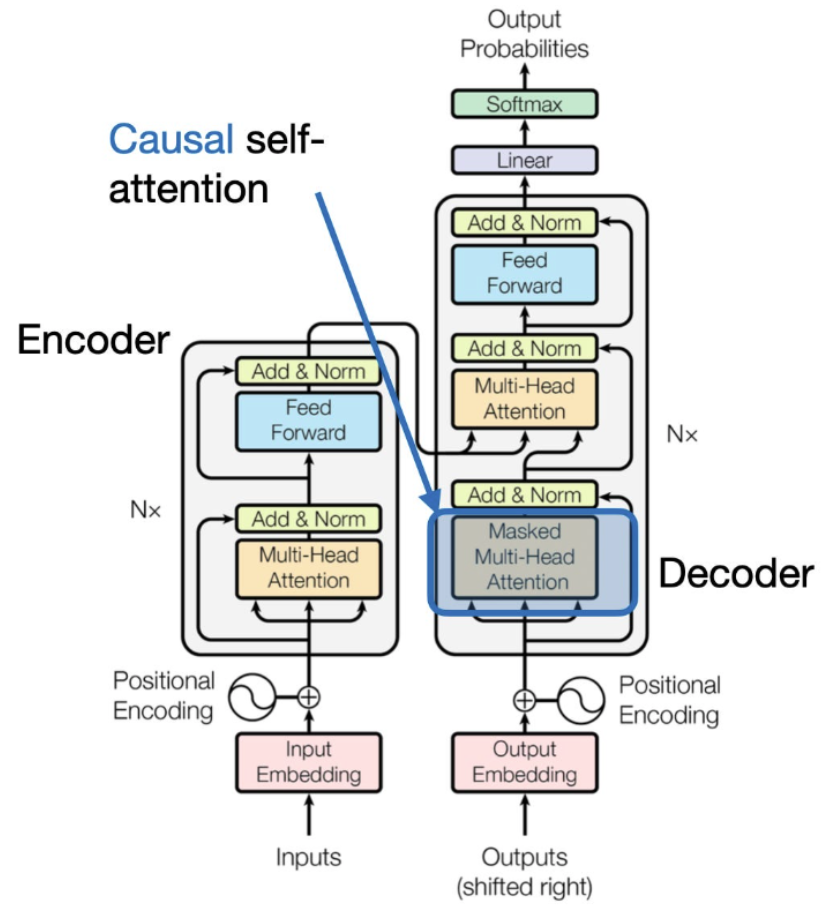

### Let's move on to  building our model

I am using the gelu activation because it tends to work well with transformers. Compared to relu, gelu blends negative and positive values, which can help the model find more subtle patterns in language. This often gives better training stability and improved overall performance.

We could have made our own gelu like this:

0.5 * x * (1.0 + tf.tanh((tf.sqrt(2.0 / tf.cast(tf.constant(1.0), x.dtype))) * (x + 0.044715 * tf.pow(x, 3))))


In [ ]:
inputs = Input(shape=(None,), dtype='int32')


Notice I used input shape none, so that the model can handle sequences of different lengths. This way, the model expect any sequence lenght, so during testing, we can get it going with one word, or with a full sentence.

In [ ]:
# token + position embedding layer
embedding_layer = TokenAndPositionEmbedding(
    vocabulary_size=vocab_size,
    sequence_length=context,
    embedding_dim=embed_dim
)

In [ ]:
x = embedding_layer(inputs)

In [ ]:
# instead of building our transformerdecoder block, with selfattention, residual
# blocks and layer norms, we just use keras transformerdecoder, that does all
# of that for us.

for _ in range(n_layer):
    x = TransformerDecoder(
        num_heads=num_heads,
        intermediate_dim=ff_dim,
        dropout=dropout,
        activation='gelu'
    )(x, use_causal_mask=True)



In [ ]:
x = LayerNormalization(epsilon=1e-5)(x)


In [ ]:
outputs = Dense(vocab_size, activation='softmax')(x)

### Final model
The model inputs a sequence of token id. These are transformed into embeddings and added positional info. Output predicts the probability of each token in the vocabulary.


In [ ]:
model = Model(inputs, outputs)

In [ ]:
# learning rate is set after a lot of experimentation
model.compile(optimizer=Adam(learning_rate=3e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, None, 512)           │       4,224,000 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder                  │ (None, None, 512)           │       3,152,384 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_1                │ (None, None, 512)           │       3,152,384 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_2                │ (None, None, 512)           │       3,152,384 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_3                │ (None, None, 512)           │       3,152,384 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_4                │ (None, None, 512)           │       3,152,384 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_5                │ (None, None, 512)           │       3,152,384 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_6                │ (None, None, 512)           │       3,152,384 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_7                │ (None, None, 512)           │       3,152,384 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_8                │ (None, None, 512)           │       3,152,384 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_9                │ (None, None, 512)           │       3,152,384 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_10               │ (None, None, 512)           │       3,152,384 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_11               │ (None, None, 512)           │       3,152,384 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, None, 512)           │           1,0

 Total params: 46,157,632 (176.08 MB)

 Trainable params: 46,157,632 (176.08 MB)

 Non-trainable params: 0 (0.00 B)

# Training
The model was trained with early stopping to prevent overfitting. On Google Colab and A100 GPU, this took me around 3 hours to train.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [ ]:
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch,
                    callbacks=[early_stopping],
                    validation_data=(x_val, y_val))


Epoch 1/1000
782/782 ━━━━━━━━━━━━━━━━━━━━ 261s 227ms/step - accuracy: 0.1042 - loss: 6.7212 - val_accuracy: 0.1319 - val_loss: 5.6939
Epoch 2/1000
782/782 ━━━━━━━━━━━━━━━━━━━━ 107s 137ms/step - accuracy: 0.1537 - loss: 5.2766 - val_accuracy: 0.1454 - val_loss: 5.4889
Epoch 3/1000
782/782 ━━━━━━━━━━━━━━━━━━━━ 107s 137ms/step - accuracy: 0.1736 - loss: 4.9883 - val_accuracy: 0.1639 - val_loss: 5.2784
Epoch 4/1000
782/782 ━━━━━━━━━━━━━━━━━━━━ 107s 137ms/step - accuracy: 0.1937 - loss: 4.7364 - val_accuracy: 0.1741 - val_loss: 5.1458
Epoch 5/1000
782/782 ━━━━━━━━━━━━━━━━━━━━ 107s 137ms/step - accuracy: 0.2082 - loss: 4.5359 - val_accuracy: 0.1802 - val_loss: 5.0659
Epoch 6/1000
782/782 ━━━━━━━━━━━━━━━━━━━━ 107s 137ms/step - accuracy: 0.2198 - loss: 4.3783 - val_accuracy: 0.1853 - val_loss: 5.0030
Epoch 7/1000
782/782 ━━━━━━━━━━━━━━━━━━━━ 107s 136ms/step - accuracy: 0.2295 - loss: 4.2480 - val_accuracy: 0.1891 - val_loss: 4.9624
Epoch 8/1000
782/782 ━━━━━━━━━━━━━━━━━━━━ 107s 137ms/step - ac

When working on language modeling tasks, I've found that focusing on reducing loss is actually more meaningful than just trying to boost accuracy. Accuracy only tells me how often the model's top prediction matches the correct next word, which is not as important as having a meaningful sentence. The loss function shows me how close the model's entire set of predicted probabilities is to the real distribution of words. Even if the model doesnt always pick the exact next word perfectly, giving higher probabilities to words that still make sense shows it understands the context better.

 Lower loss means the model is generally doing a better job of thinking about all the possibilities.

In [ ]:
# If you'd like to save it
model.save('transformer10.keras')

# Plot the loss

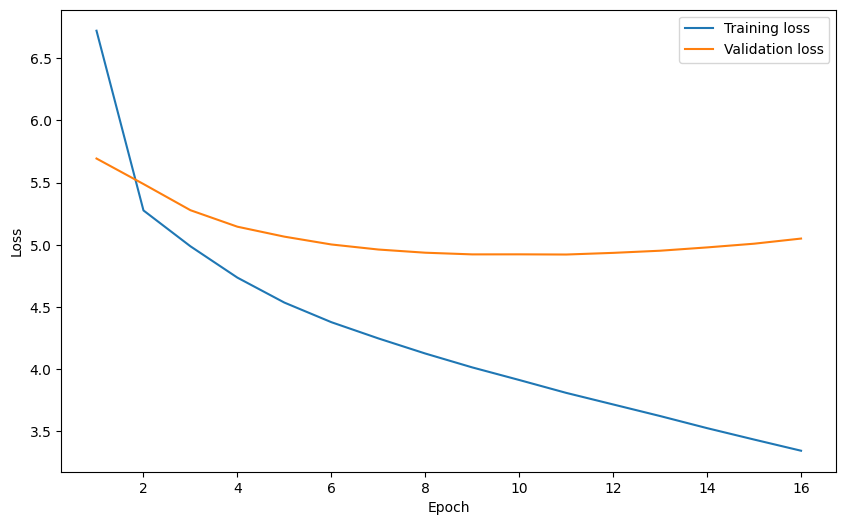

In [ ]:
df = pd.DataFrame(history.history)

plt.figure(figsize=(10,6)) #making it bigger
plt.plot(df.index + 1, df['loss'], label='Training loss')
plt.plot(df.index + 1, df['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

As I trained my model over these 16 epochs, I noticed that the training loss steadily went down from about 6.72 to around 3.35, which means the model was getting better at fitting the training data. However, the validation loss started high and then stopped improving after around the 9th or 10th epoch, then getting worse. This means that the model learned the training fata, but it did not generalize to the validation set. This means that the model started to overfit - getting better at the training set but not at the unseen validation data.

# Predictions

I decided to stick with greedy search because it kept things simple. By always choosing the most likely next token, I didn't have to deal with extra parameters or more complex sampling methods. While this did make the generated text less interesting and much more repetitive, it also gave me a clearer look at what the model really *wants* to say at each step. Considering my limited time and computing resources, greedy search was an easier way to test and understand the model's basic abilities without adding too much complexity.

I only predicted 50 tokens at a time, as the environment kept crashing if not. So I test different sentences in the model and generate 50 tokens each based on it

In [ ]:

def generate_text(number = 50, print_all=True):
    tokens = sp.encode_as_ids(test_text)
    start_tokens = np.array(tokens)[None, :]  # shape 1, 1

    for _ in range(number):  # generate 50 tokens
        u = start_tokens[:, -context:]
        logits = model.predict(u, verbose=0)  # shape 1, current_length, vocab_size
        next_token = np.argmax(logits[:, -1, :], axis=-1)  # take the most likely next token
        start_tokens = np.concatenate([start_tokens, next_token[:, None]], axis=1)

    generated_text = sp.decode_ids(start_tokens[0].tolist())
    if print_all:
        u = 0
    else:
      u = len(test_text)
    print(generated_text[u:])
    if print_all == False:
      return generated_text


### Prediction 1

In [ ]:
test_text = 'to bait the trap for you. You fell into the trap, and you will'

In [ ]:
start_tokens = sp.encode_as_ids(test_text)

In [ ]:
start_tokens = np.array(start_tokens)[None, :]  # shape (1, 1)

start_tokens

array([[  27, 5377,   42,   10, 3740,   92,   49, 7991, 7969,    0,   17,
        1331,  246,   10, 3740, 7988,   33,   49,  209]])

I am creating a function that can generate text to me. I had to keep it at 50 tokens, if not, my environment kept crashing.

In [ ]:
generate_text()

to bait the trap for you.  ⁇ ou fell into the trap, and you will find it in the same way. i will tell you, watson, that i am not aware that i am not in the habit of making a little use of the matter. i have no doubt that i am not aware that i am not in the


test_text = 'to bait the trap for you. You fell into the trap, and you will'

**generated: find it in the same way. i will tell you, watson, that i am not aware that i am not in the habit of making a little use of the matter. i have no doubt that i am not aware that i am not in the**

### Prediction 2

In [ ]:
test_text = '''
having been cajoled into putting that prize of two thousand pounds in your
'''

In [ ]:
generate_text(number = 75, print_all=True)

having been cajoled into putting that prize of two thousand pounds in your hands. i have no doubt that you have not been in the hands of the case. i have not seen the facts before. i have been able to tell you that the case is a very interesting one. i have not a doubt of the case. i have not a doubt that it is a very simple one. i have a very good deal to say that i have


Generated: **hands. i have no doubt that you have not been in the hands of the case. i have not seen the facts before. i have been able to tell you that the case is a very interesting one. i have not a doubt of the case. i have not a doubt that it is a very simple one. i have a very good deal to say that i have**

### Prediction 3

In [ ]:
test_text = '''
in your power, I was to be done to death with brandy, and, brandy not proving quick enough, with something
'''

In [ ]:
generate_text()

in your power,  ⁇  was to be done to death with brandy, and, brandy not proving quick enough, with something which i had seen in my hands. i was not aware that i had not seen the man. i was not a man of the sort, but i could not imagine that i was a man. i was a man, and i was a man


Generated: **which i had seen in my hands. i was not aware that i had not seen the man. i was not a man of the sort, but i could not imagine that i was a man. i was a man, and i was a man**

### Prediction 4

In [ ]:
test_text = '''

quicker? have I never seen you, when you thought my senses gone, pouring from your little bottle into my glass? why, you Murderer and Forger, alone here with you in the dead of night, as I have so often been, I have had my hand upon the trigger of a pistol, twenty times, to blow your brains out!’ \n This sudden starting

'''

In [ ]:
generate_text()

your plot has been known to both of us, all along, and you have been counter ⁇ plotted all along; what? having been cajoled into putting that prize of two thousand pounds in your power,  ⁇  was to be done to death with brandy, and, brandy not proving quick enough, with something quicker? have  ⁇  never seen you, when you thought my senses gone, pouring from your little bottle into my glass? why, you  ⁇ urderer and  ⁇ orger, alone here with you in the dead of night, as  ⁇  have so often been,  ⁇  have had my hand upon the trigger of a pistol, twenty times, to blow your brains out ⁇   ⁇ his sudden startingpoint for the first time. i had a good deal of you, mr. holmes, said he, with a smile. i am not a very much obliged to you, mr. holmes, but i have not yet seen a little more of my


Input: quicker? have I never seen you, when you thought my senses gone, pouring from your little bottle into my glass? why, you Murderer and Forger, alone here with you in the dead of night, as I have so often been, I have had my hand upon the trigger of a pistol, twenty times, to blow your brains out!’ \n This sudden starting

Generated: **point for the first time. i had a good deal of you, mr. holmes, said he, with a smile. i am not a very much obliged to you, mr. holmes, but i have not yet seen a little more of my**

### Prediction 5

In [ ]:
test_text = '''
Who was it
'''

In [ ]:
print(test_text)


Who was it



In [ ]:
test_text = generate_text(print_all=False)

 not? yes, i said, in a low voice. i am afraid, said i, that you have not heard of the truth. i have no doubt that you have not heard of it. i have no doubt that you have not heard of


In [ ]:
test_text = generate_text(print_all=False)

 it. i have no doubt that you have not heard of it. i have no doubt that it is a very serious matter. i have no doubt that it is a very serious one. i have no doubt that it is a very serious one.


# Conclusion

The predictions my model produced show that, even though I only used a relatively small dataset and a not-so-large model, it can still learn to generate text that sounds somewhat like the source material. While the generated text may not always make perfect logical sense, it usually stays on topic and maintains a writing style that is similar to the books I trained it on. When the model tries to predict the next token, it reflects the patterns it has learned—things like basic grammar and some sense of context. This indicates that the transformer’s attention mechanisms do help the model understand relationships across longer parts of the text. If I had more training data, a bigger model, and more time to train it, I believe the generated text would become more coherent, relevant, and closer to human-like writing.

Multiple Gutenberg books introduce stylistic variety and complexity.

# Tips

 chose not to use data generators in this final model to make it more educational and easier for the reader to follow along and understand every part of the training process. data generators are often better, in transformers because we don't have to load all the data in memory, and the model get's to see more data, since the data is sampled again every epoch.

 This simpler setup helps keep the focus on showing how a transformer model is built, trained, and evaluated, without complex data pipeline.

That the text underneath is so much better, illustrates that Transformers needs a lot of data to perform well.

It was trained with 64 batches and 500 steps each epoch, for 10 epochs. So in total it got to see ...

In [ ]:
64*500

32000

...32000 sequences every epoch, and instead of seeing the same sequences, it would see new ones. So in total it saw...

In [ ]:
32000*10

320000

320 000 sequences. This is much more than the 50 000 it originally saw

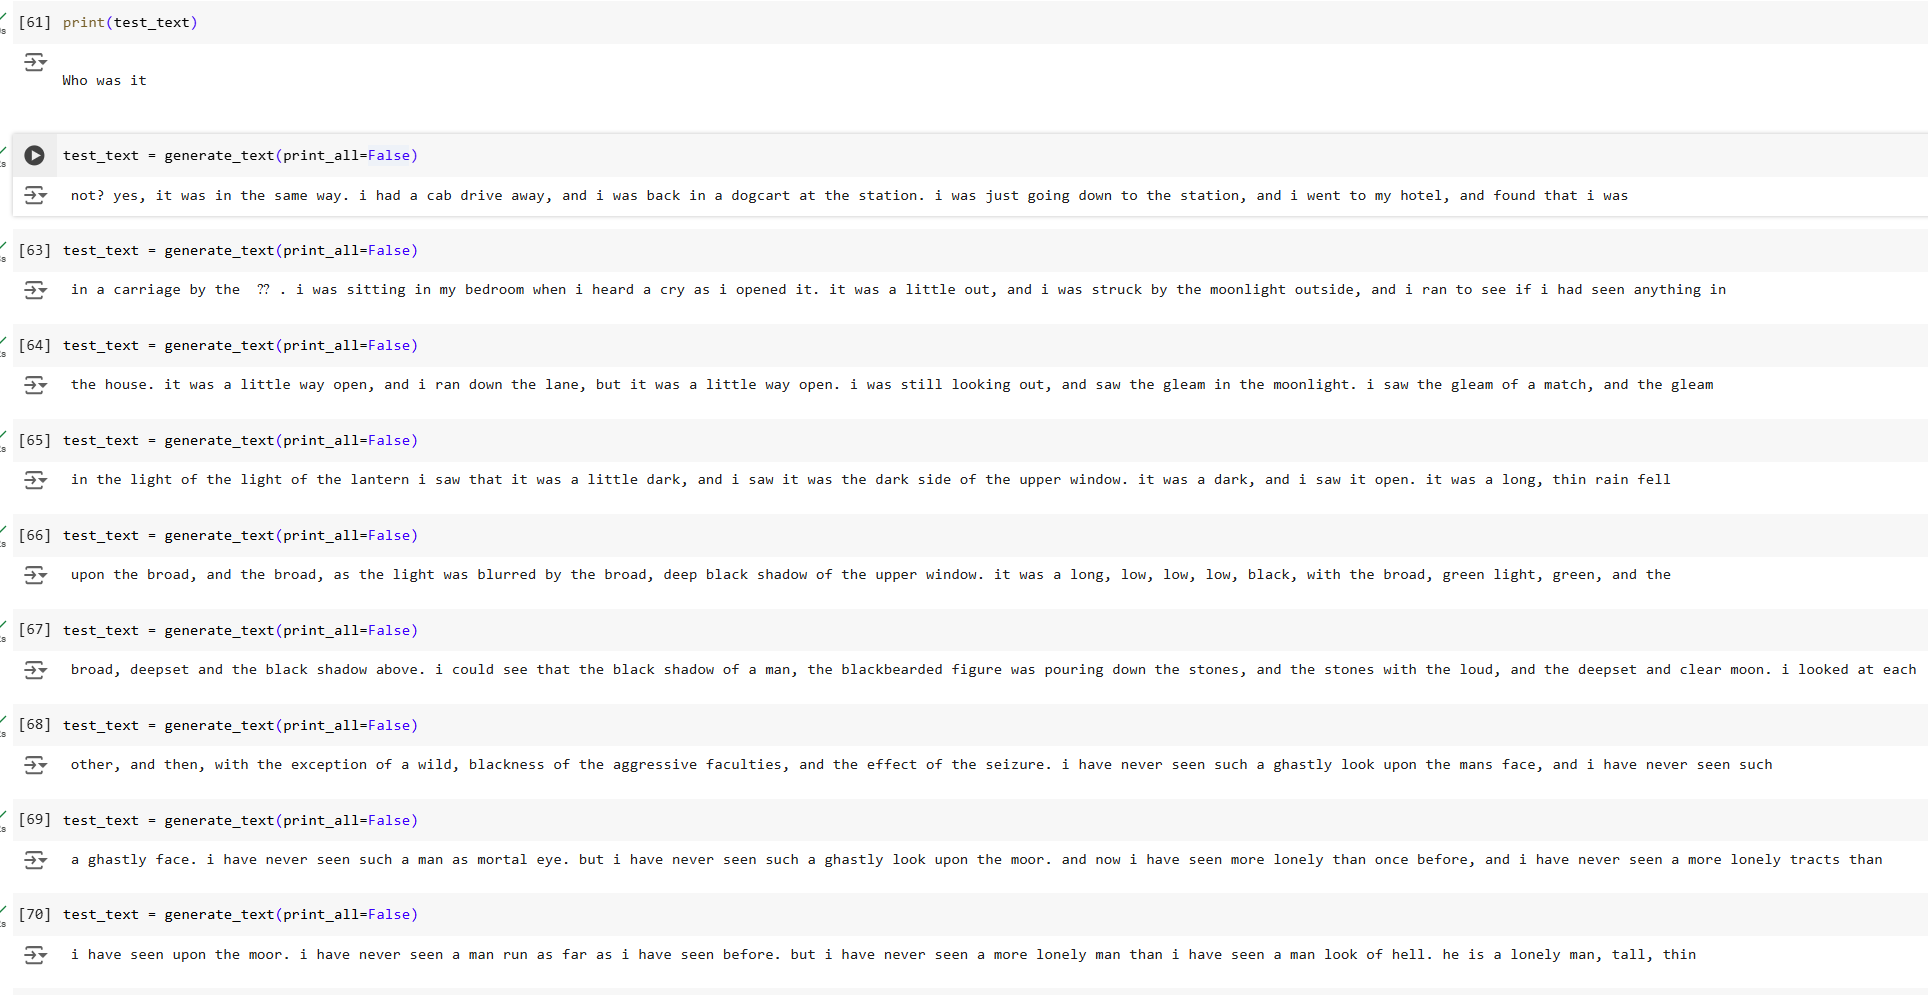